## Imports

In [2]:
# Install necessary libraries
!pip install torch transformers
# Install Gensim
!pip install gensim
!pip install torch-geometric
!pip install dgl


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
    --------------------------------------- 0.5/24.0 MB 15.9 MB/s eta 0:00:02
   --- ------------------------------------ 2.3/24.0 MB 36.4 MB/s eta 0:00:01
   ------------- -------------------------- 8.2/24.0 MB 65.5 MB/s eta 0:00:01
   -------------------- ------------------- 12.3/24.0 MB 93.9 MB/s eta 0:00:01
   --------------------------- ------------ 16.6/24.0 MB 108.8 MB/s eta 0:00:01
   ---------------------------------- ----- 20.5/24.0 MB 93.9 MB/s eta 0:00:01
   ---------------------------------------  23.6/24.0 MB 81.8 MB/s eta 0:00:01
   ---------------------------------------- 24.0/24.0 MB 65.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.0 kB ? eta -:--:--
   ---------------------------------------- 57.0/57.0 kB ? eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/63.9 kB ? eta -:--:--
     ---------------------------------------- 63.9/63.9 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------  1.0/1.0 MB 32.7 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 33.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
import regex as re
import networkx as nx
import torch
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from itertools import combinations
import numpy as np
from scipy.spatial.distance import euclidean
from transformers import RobertaTokenizer, RobertaModel
from imblearn.under_sampling import RandomUnderSampler
import random
from sklearn.metrics import roc_auc_score
import dgl
import dgl.nn.pytorch as dglnn
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from dgl.nn import GATConv
import matplotlib.pyplot as plt



## Submission Flag

In [4]:
is_submission = False

## Read Datasets

In [5]:
train_path1 = r"data\train_v2_drcat_02.csv" if not is_submission else r"/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv"
train_path2 = r"data\train_essays.csv" if not is_submission else r"/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
test_path = r"data\test_essays.csv" if not is_submission else r"/kaggle/input/llm-detect-ai-generated-text/test_essays.csv"
train_data1 = pd.read_csv(train_path1)
train_data1.rename(columns={'label': 'generated'}, inplace=True)
train_data2 = pd.read_csv(train_path2)
test_data = pd.read_csv(test_path)

In [6]:
train = pd.concat([train_data1[['text','generated']], train_data2[['text','generated']]])
train['text'] = train['text'].str.replace('\n', '')
test_data['text'] = test_data['text'].str.replace('\n', '')
train['generated'].value_counts()

generated
0    28746
1    17500
Name: count, dtype: int64

In [10]:
rus = RandomUnderSampler(random_state=42)
train_text, train_label = rus.fit_resample(train['text'].to_numpy().reshape(-1,1), train['generated'].to_numpy().reshape(-1,1))
print('0: ', np.count_nonzero(train_label == 0))
print('1: ', np.count_nonzero(train_label == 1))

data = {'text': train_text.reshape(-1), 'generated': train_label.reshape(-1)}
all_data = pd.DataFrame(data)

if not is_submission:
    seed=202
    random.seed(seed)
    np.random.seed(seed)
    mask = np.random.rand(len(all_data)) < 0.8
    test_data = all_data[~mask]
    train_data = all_data[mask]

0:  17500
1:  17500
                                                    text  generated
0      In today's modern world, there has been techno...          0
1      True AutomobilesI can imagine a future where n...          0
2      Dear Principal,I think you should let students...          0
3      Ever been too sick to be at school and you mis...          0
4      Many kids will believe that having to attend c...          0
...                                                  ...        ...
34995  Dear Senator,I am writing to you today to expr...          1
34996  Dear Senator,I am writing to you today to expr...          1
34997  This essay will analyze, discuss and prove one...          1
34998  I strongly believe that the Electoral College ...          1
34999  Limiting car use causes pollution, increases c...          1

[35000 rows x 2 columns]


## Embeddings

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Euclidean Dist:  3.642890691757202
Doc2Vec Similarity:  0.83248353
Euclidean Dist:  8.699429512023926
Doc2Vec Similarity:  0.72738034
Euclidean Dist:  2.2489943504333496
Doc2Vec Similarity:  0.9402723
Euclidean Dist:  5.347766399383545
Doc2Vec Similarity:  0.73876566
Euclidean Dist:  4.628847599029541
Doc2Vec Similarity:  0.7738781
Euclidean Dist:  8.809070587158203
Doc2Vec Similarity:  0.6073997
Euclidean Dist:  2.500016689300537
Doc2Vec Similarity:  0.9401577
Euclidean Dist:  10.622872352600098
Doc2Vec Similarity:  0.40601847
Euclidean Dist:  7.022533893585205
Doc2Vec Similarity:  0.553372
Euclidean Dist:  2.646256685256958
Doc2Vec Similarity:  0.9304806
Euclidean Dist:  4.6028618812561035
Doc2Vec Similarity:  0.74908626
Euclidean Dist:  7.985752582550049
Doc2Vec Similarity:  0.54310197
Euclidean Dist:  4.02661657333374
Doc2Vec Similarity:  0.91788906
Euclidean Dist:  6.421029090881348
Doc2Vec Similarity:  0.62747955
Euclidean Dist:  5.538548469543457
Doc2Vec Similarity:  0.8738506
E

NameError: name 'plt' is not defined

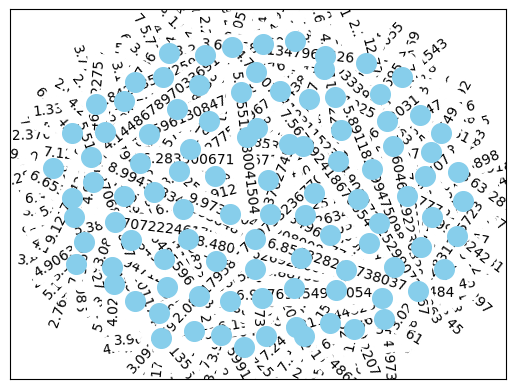

In [11]:
# Step 1: Data Preparation
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta = RobertaModel.from_pretrained('roberta-base')
# Sample list of texts with labels
texts_list = train_data['text'].to_list()

labels_list = train_data['generated'].to_list()  # Sample labels (0 or 1 for classification)

# Step 2: RoBERTa Embedding

# Tokenize and obtain embeddings for each text entry
roberta_embeddings_list = []


for text in texts_list:
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        output = roberta(**encoded_input)
    last_hidden_states = output.last_hidden_state
    # For simplicity, let's use the [CLS] token representation as the sentence embedding
    cls_embedding = last_hidden_states[:, 0, :].squeeze().numpy()
    roberta_embeddings_list.append(cls_embedding)
# Step 3: Graph Construction

# Step 1: Convert texts to TaggedDocuments
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(texts_list)]

# Step 2: Train Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Step 3: Calculate similarity/distance
doc2vec_embeddings_list = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data]

# Step 4: Calculate similarity/distance between embeddings
for pair in combinations(doc2vec_embeddings_list, 2):
    doc1, doc2 = pair
    print('Euclidean Dist: ', euclidean(doc1, doc2))
    # Calculate similarity manually (cosine similarity can be approximated)
    similarity = np.dot(doc1, doc2) / (np.linalg.norm(doc1) * np.linalg.norm(doc2))
    print('Doc2Vec Similarity: ', similarity)

# Step 5: Create a networkx Graph with Node and Edge Features
G = nx.Graph()

# Add nodes with RoBERTa embeddings as roberta_embeddings_list
for i, embedding in enumerate(roberta_embeddings_list):
    G.add_node(i, features=embedding)

# Add edges with Euclidean distance and Doc2Vec similarity as features
for idx, pair in enumerate(combinations(enumerate(doc2vec_embeddings_list), 2)):
    (idx1, doc1), (idx2, doc2) = pair
    euclidean_dist = euclidean(doc1, doc2)
    similarity = np.dot(doc1, doc2) / (np.linalg.norm(doc1) * np.linalg.norm(doc2))
    G.add_edge(idx1, idx2, euclidean_dist=euclidean_dist, doc2vec_similarity=similarity)


# Create a layout for the nodes
pos = nx.spring_layout(G)

# Extract node features
node_features = nx.get_node_attributes(G, 'features')

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue')

# Draw edges with edge features (Euclidean distance)
edge_labels = nx.get_edge_attributes(G, 'euclidean_dist')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw edge labels (Euclidean distance)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the plot
plt.title('Graph Visualization with Node and Edge Features')
plt.axis('off')
plt.show()

## Create Model

In [12]:
# ... (previous code for creating the networkx graph 'G' with node and edge features)

# Step 6: Convert NetworkX graph to DGL graph
dgl_G = dgl.from_networkx(G)

# Step 7: Define a GAT model
class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_layers):
        super(GAT, self).__init__()

        # Initialize list to hold the layers
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(dglnn.GATConv(in_feats, hidden_feats, num_heads=8, residual=True))

        # Hidden layers
        for _ in range(num_layers - 2):  # -2 as input and output layers are accounted for
            self.layers.append(dglnn.GATConv(hidden_feats * 8, hidden_feats, num_heads=8, residual=True))

        # Output layer
        self.layers.append(dglnn.GATConv(hidden_feats * 8, out_feats, num_heads=1, residual=True))

        # Feedforward network and softmax for classification
        self.classify = nn.Sequential(
            nn.Linear(out_feats, 128),  # Example: 128 hidden units in the feedforward network
            nn.ReLU(),
            nn.Linear(128, 2)  # Assuming binary classification (change output size accordingly)
        )

    def forward(self, g, features):
        h = features

        # Iterate through layers
        for layer in self.layers:
            h = layer(g, h).flatten(1)

        # Classification
        logits = self.classify(h)
        return logits

# Step 8: Split the data into train and test sets
labels = torch.tensor(labels_list, dtype=torch.float32).view(-1, 1)
train_idx, test_idx = train_test_split(np.arange(len(labels_list)), test_size=0.2, random_state=42)

train_mask = torch.zeros(len(labels_list), dtype=torch.bool)
train_mask[train_idx] = True

# Step 9: Prepare data and train the GAT model
model = GAT(in_feats=roberta_embeddings_list[0].shape[0], hidden_feats=64, out_feats=64, num_layers=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    logits = model(dgl_G, torch.tensor(roberta_embeddings_list, dtype=torch.float32))
    logits = logits.squeeze(1)  # Squeeze unnecessary dimensions

    optimizer.zero_grad()
    loss = criterion(logits[train_idx], torch.tensor(labels_list, dtype=torch.long)[train_idx])
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1} | Loss: {loss.item()}")

# Step 10: Evaluate the model on the test set
model.eval()
logits = model(dgl_G, torch.tensor(roberta_embeddings_list, dtype=torch.float32))
logits = logits[test_idx]
predictions = (torch.sigmoid(logits) > 0.5).float()

# Calculate accuracy
correct = (predictions == labels[test_idx]).sum().item()
accuracy = correct / len(test_idx)
print(f"Test Set Accuracy: {accuracy}")

C:\Users\christoph.landolt\AppData\Local\Temp\ipykernel_29916\3547600477.py:65: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  logits = model(dgl_G, torch.tensor(roberta_embeddings_list, dtype=torch.float32))


Epoch 1 | Loss: 38.212894439697266
Epoch 2 | Loss: 2720.93994140625
Epoch 3 | Loss: 275206.75
Epoch 4 | Loss: 4677.34521484375
Epoch 5 | Loss: 148899.6875
Epoch 6 | Loss: 356149.71875
Epoch 7 | Loss: 2424395.0
Epoch 8 | Loss: 42037352.0
Epoch 9 | Loss: 931129.3125
Epoch 10 | Loss: 3999.897705078125
Epoch 11 | Loss: 2061952.75
Epoch 12 | Loss: 31471616.0
Epoch 13 | Loss: 303760.0625
Epoch 14 | Loss: 2290.744384765625
Epoch 15 | Loss: 24902.70703125
Epoch 16 | Loss: 56456.51953125
Epoch 17 | Loss: 4954.1005859375
Epoch 18 | Loss: 265221.0
Epoch 19 | Loss: 328594.28125
Epoch 20 | Loss: 642062.9375
Epoch 21 | Loss: 4010662.5
Epoch 22 | Loss: 54316456.0
Epoch 23 | Loss: 91774144.0
Epoch 24 | Loss: 91113616.0
Epoch 25 | Loss: 6562675712.0
Epoch 26 | Loss: 5354210304.0
Epoch 27 | Loss: 4049748736.0
Epoch 28 | Loss: 8484822016.0
Epoch 29 | Loss: 25466868.0
Epoch 30 | Loss: 460195776.0
Epoch 31 | Loss: 997274624.0
Epoch 32 | Loss: 400801536.0
Epoch 33 | Loss: 152340704.0
Epoch 34 | Loss: 319865

## Predict Test Set

In [ ]:
# Tokenize and obtain embeddings for each text entry
test_roberta_embeddings_list = []

test_text_list = test_data['text'].to_list()
for text in test_text_list:
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        output = roberta(**encoded_input)
    last_hidden_states = output.last_hidden_state
    # For simplicity, let's use the [CLS] token representation as the sentence embedding
    cls_embedding = last_hidden_states[:, 0, :].squeeze().numpy()
    roberta_embeddings_list.append(cls_embedding)
# Step 3: Graph Construction
    
unlabeled_features = torch.tensor(test_roberta_embeddings_list, dtype=torch.float32)

# Step 2: Set model to evaluation mode
model.eval()

# Step 3: Predict logits for unlabeled nodes
with torch.no_grad():
    logits_unlabeled = model(dgl_G, unlabeled_features)
    logits_unlabeled = logits_unlabeled.squeeze(1)  # Squeeze unnecessary dimensions

# Step 4: Apply threshold (e.g., sigmoid) for binary predictions
preds_val = (torch.sigmoid(logits_unlabeled) > 0.5).float()


## Performance and Create Submission

In [ ]:
if not is_submission:
    print('ROC AUC val:', roc_auc_score(test_data.generated, preds_val))
else:
    submission = pd.DataFrame({'id':test_data["id"], 'generated':predictions})
    submission_path = r"/kaggle/working/submission.csv"
    submission.to_csv(submission_path, index=False)

ROC AUC train: 0.9930497268286299
ROC AUC val: 0.5104081652548534
